# Selected code for report comparison pipeline

In [168]:
# !pip install opencv-python matplotlib pandas numpy scikit-learn pyproj kneed --quiet

In [ ]:
import os
import re
import cv2
import math
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kneed import KneeLocator


from pyproj import Transformer

distances = [10,20,30,40,50,75,100]

# File Handling and CLI Support

## File handling helpers

In [170]:
def get_file_name(filepath: str) -> str:
    """
    Extracts the file name from a given file path.
    
    Args:
        filepath (str): The full path to the file.
        
    Returns:
        str: The file name without the extension.
    """
    return os.path.splitext(os.path.basename(filepath))[0] if os.path.isfile(filepath) else None

def check_if_video_file(filepath: str) -> bool:
    """
    Checks if the given file is a video file based on openCV's video capture functionality.
    
    Args:
        filepath (str): The full path to the file.
        
    Returns:
        bool: True if the file is a video, False otherwise.
    """

    if not os.path.isfile(filepath):
        return False
    
    video = cv2.VideoCapture(filepath)
    if not video.isOpened():
        return False
    
    video.release()
    return True
    
def get_frame_count(filepath: str) -> int:
    """
    Retrieves the total number of frames in a video file.
    
    Args:
        filepath (str): The full path to the video file.
        
    Returns:
        int: The total number of frames in the video.
    """
    
    if not check_if_video_file(filepath):
        raise Exception(f"File {filepath} is not a valid video file.")
    
    video = cv2.VideoCapture(filepath)
    frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.release()
    
    return frame_count

def get_frame_rate(filepath: str) -> float:
    """
    Retrieves the frame rate of a video file.
    
    Args:
        filepath (str): The full path to the video file.
        
    Returns:
        float: The frame rate of the video.
    """
    
    if not check_if_video_file(filepath):
        raise Exception(f"File {filepath} is not a valid video file.")
    
    video = cv2.VideoCapture(filepath)
    fps = video.get(cv2.CAP_PROP_FPS)
    video.release()
    
    return fps

## Initialization of files and paths

In [171]:
# Lets keep these as a simple relative environment
OUTPUT_PATH = './'
INPUT_FILE = '43.MP4'
# INPUT_FILE = '250222_084809_021_RH.MP4'

CLI override on OUTPUT_PATH and INPUT_FILE

In [172]:
parser = argparse.ArgumentParser(
    description="Process input and output paths for video processing."
)

parser.add_argument(
    "-i", "--input", 
    help="Path to the input video file.", 
    required=False
)

parser.add_argument(
    "-o", "--output", 
    help="Path to the output folder.", 
    required=False
)

parser.add_argument(
    "--f", "--kernel_launcher", 
    help="Path to the kernel launcher file.",
    required=False
)


args = parser.parse_args()

if args.input and args.output:
    args = parser.parse_args()
    
    INPUT_FILE = args.input
    OUTPUT_PATH = args.output
    print("System arguments detected:", args)



In [173]:
from pickle import FRAME


if not check_if_video_file(INPUT_FILE):
    raise ValueError(f"Input file {INPUT_FILE} is not a valid video file.")

FILE_NAME = get_file_name(INPUT_FILE)
OUTPUT_PATH = os.path.join(OUTPUT_PATH, FILE_NAME)
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
TOTAL_FRAME_COUNT = get_frame_count(INPUT_FILE)
FRAME_RATE = get_frame_rate(INPUT_FILE)

print(f"Input file: {INPUT_FILE}, Total frames: {TOTAL_FRAME_COUNT}, Frame rate: {FRAME_RATE}")

ValueError: Input file 43.MP4 is not a valid video file.

# NMEA Data Fetching and Cleaning

In [ ]:
def getNMEAStringsFromFile(file_path:str, min_string_length:int=9) -> list:
    """Get the NMEA strings from the file

    Args:
        file_path (str): The path to the file

    Returns:
        List[str]: The GPRMC|GPGGA strings from the file
    """
    strings = ""
    with open(file_path, "rb") as f:
        strings = f.read()

    pattern =  rb'\$(?:GPRMC|GPGGA)[ -~]{' + str(min_string_length).encode() + rb',}'
    strings = re.findall(pattern, strings)    
    return [s.decode('utf-8', errors='ignore') for s in strings]

In [ ]:
nmea_strings = getNMEAStringsFromFile(INPUT_FILE)
if len(nmea_strings) == 0:
    raise ValueError(f"No NMEA strings found in {INPUT_FILE}.")

print(f"Found {len(nmea_strings)} NMEA strings in {INPUT_FILE}.")
nmea_strings[:5]

Found 4094 NMEA strings in 250222_084809_021_RH.MP4.


['$GPRMC,084810.600,A,5315.15482,N,00153.88158,W,38.170,93.49,220225,,,A*5D',
 '$GPGGA,084810.600,5315.15482,N,00153.88158,W,1,07,1.51,280.6,M,49.2,M,,*61',
 '$GPRMC,084810.700,A,5315.15477,N,00153.87982,W,38.168,90.88,220225,,,A*51',
 '$GPGGA,084810.700,5315.15477,N,00153.87982,W,1,07,1.51,280.5,M,49.2,M,,*69',
 '$GPRMC,084810.800,A,5315.15475,N,00153.87806,W,38.322,93.89,220225,,,A*5F']

## Parse NMEA Strings to Objects

In [ ]:
def knots_to_mph(knots:float) -> float:
    """Convert knots to miles per hour

    Args:
        knots (float): The speed in knots

    Returns:
        float: The speed in miles per hour
    """
    return knots * 1.150779448


def DM_to_decimal(dm: str, heading: str) -> float:
    """Convert degrees and minutes to decimal degrees

    Args:
        dm (str): The degrees and minutes string
        heading (str): The heading (N, S, E, W)
    
    Returns:
        float: The decimal degrees
    """
    heading = heading.upper()
    deg_len = 3 if len(dm.split('.')[0]) > 4 else 2
    deg = int(dm[:deg_len])
    minute = float(dm[deg_len:])
    dec = deg + minute/60

    if heading in ('S','W'):
        dec = -dec
    elif heading not in ('N','E'):
        raise ValueError(f"Invalid heading: {heading!r}")
    return dec

def time_to_seconds(time_str: str) -> float:
    """
    Given time as "hhmmss.sss", return total seconds since midnight.
    E.g. "123519.045" → 12*3600 + 35*60 + 19.045 = 45319.045
    
    Args:
        time_str (str): Time string in the format "hhmmss.sss".

    Returns:
        float: Total seconds since midnight.
    """
    # split out fractional seconds if present
    if '.' in time_str:
        main, frac = time_str.split('.')
        frac = float('0.' + frac)
    else:
        main, frac = time_str, 0.0

    hh = int(main[0:2])
    mm = int(main[2:4])
    ss = int(main[4:6])

    return hh * 3600 + mm * 60 + ss + frac

In [ ]:
lat = DM_to_decimal("4530.0000", "N")    # → 45.5
lon = DM_to_decimal("12330.0000", "W")   # → -123.5
mph = knots_to_mph(10)
time = time_to_seconds("123519.045")  # → 45319.045
print(f"Latitude: {lat}, Longitude: {lon}, Speed: {mph} mph, Time: {time} seconds")

Latitude: 45.5, Longitude: -123.5, Speed: 11.50779448 mph, Time: 45319.045 seconds


In [ ]:
def parse_gprmc(input_sequence:str) -> dict:
    """Parse the GPRMC and GPGGA string and extract the latitude, longitude, height and speed

    Args:
        input_sequence (str[]): [GPRMC string, GPGGA string]

    Returns:
        dict: The extracted values as a dictionary
    """
    rmc, gga = input_sequence
    # $GPRMC,<time>,<status>,<latitude>,<N/S>,<longitude>,<E/W>,<speed>,<course>,<date>,<magnetic variation>,<E/W>,<checksum>
    parts_rmc = rmc.split(',')
    # $GPGGA,<time>,<latitude>,<N/S>,<longitude>,<E/W>,<quality>,<number of satellites>,<horizontal dilution of precision>,<altitude>,<units>,<geoidal separation>,<units>,<age of differential GPS data>,<reference station ID>,<checksum>
    parts_gga = gga.split(',')
    
    if parts_rmc[0] != '$GPRMC' or len(parts_rmc) < 12:
        return None
    if parts_gga[0] != '$GPGGA' or len(parts_gga) < 15:
        return None

    
    # Extract latitude and longitude with direction
    try:
        time = time_to_seconds(parts_rmc[1])
        valid = True if parts_rmc[2] == "A" else False # A - data valid, V - data invalid
        latitude = parts_rmc[3]
        lat_direction = parts_rmc[4]
        longitude = parts_rmc[5]
        lon_direction = parts_rmc[6]
        height = parts_gga[9]  # Height above sea level
        speed = parts_rmc[7]  # Speed in knots

        # Convert latitude and longitude to decimal
        DD_lat = DM_to_decimal(latitude, lat_direction)
        DD_lon = DM_to_decimal(longitude, lon_direction)

        speed = knots_to_mph(float(speed))  # Convert speed to mph
            
        # Return the extracted values as a dictionary
        return {
            "time": time,
            "valid": valid,
            "latitude": DD_lat,
            "longitude": DD_lon,
            "height": height,
            "speed": speed
        }
    except Exception as e:
        print(f"Error parsing GPRMC/GPGGA string: {e}")
        return None

In [ ]:
nmea_records = []
for i in range(len(nmea_strings)-1):
    record = parse_gprmc((nmea_strings[i], nmea_strings[i+1]))
    if record:
        nmea_records.append(record)
print(f"Parsed {len(nmea_records)} NMEA records from {len(nmea_strings)} strings.")

if len(nmea_records) == 0:
    raise ValueError(f"No valid NMEA records found in {INPUT_FILE}.")


nmea_records[:2]  # Display the first 5 records

nmea_records_df = pd.DataFrame(nmea_records)
nmea_records_df.to_csv(os.path.join(OUTPUT_PATH, "nmea.csv"), index=False)

Parsed 2047 NMEA records from 4094 strings.


In [ ]:
# 1. Load your CSV
nmea_records_df['time'] = nmea_records_df['time'].astype(float)

# 2. Compute the inter‑sample interval
nmea_records_df['dt'] = nmea_records_df['time'].diff()

# 3. Define a 10 Hz window (±20 ms tolerance here)
T = 0.1
tol = 0.02
mask = nmea_records_df['dt'].between(T - tol, T + tol)

# 4. Optionally, you may want to require runs of at least, say, 100 consecutive 10 Hz points
min_run = 100
#   identify contiguous runs
nmea_records_df['run_id'] = (mask != mask.shift()).cumsum()
run_lengths = mask.groupby(nmea_records_df['run_id']).sum()
good_runs = run_lengths[run_lengths >= min_run].index

# 5. Final selection
df_10hz = nmea_records_df[nmea_records_df['run_id'].isin(good_runs) & mask].copy()
df_10hz

,time,valid,latitude,longitude,height,speed,dt,run_id
1,31690.7,True,53.252580,-1.897997,280.5,43.922950,0.1,2
2,31690.8,True,53.252579,-1.897968,280.5,44.100170,0.1,2
3,31690.9,True,53.252578,-1.897938,280.5,44.188780,0.1,2
4,31691.0,True,53.252577,-1.897909,280.5,44.517903,0.1,2
5,31691.1,True,53.252575,-1.897879,280.5,44.478776,0.1,2
...,...,...,...,...,...,...,...,...
1797,31870.3,True,53.249271,-1.855446,239.7,43.161134,0.1,2
1798,31870.4,True,53.249266,-1.855418,239.7,42.704275,0.1,2
1799,31870.5,True,53.249261,-1.855391,239.7,42.677807,0.1,2
1800,31870.6,True,53.249256,-1.855363,239.8,42.600704,0.1,2


In [ ]:
# move time to start of the run
df_10hz['time'] = df_10hz['time'] - df_10hz['time'].min()

1801 [0.0, 0.09999999999854481, 0.2000000000007276, 0.2999999999992724, 0.3999999999978172]
1801 [0.0, 0.09999999999854481, 0.2000000000007276, 0.2999999999992724, 0.3999999999978172]


Text(0.5, 1.0, 'Time Difference Between NMEA Records')

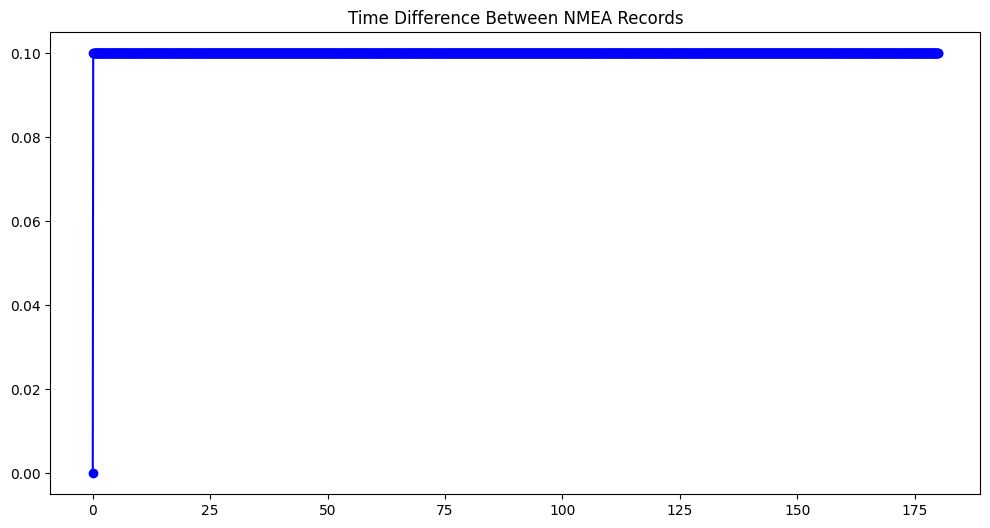

In [ ]:
times = [record['time'] for record in df_10hz.to_dict(orient='records')]
print(len(times), times[:5])
# Filter out invalid times (greater than 40000 seconds)
print (len(times), times[:5])
# get_diff_from_previous_element
time_diff = [0] + [times[i] - times[i-1] for i in range(1, len(times))]

plt.figure(figsize=(12, 6))
plt.plot(times, time_diff, marker='o', linestyle='-', color='b')
plt.title('Time Difference Between NMEA Records')

# GPS Data Formats

In [ ]:
def lat_lon_to_BGS_X_Y(lat: float, lon: float) -> tuple[float, float]:
    """
    Convert latitude/longitude (EPSG:4326) to British National Grid
    eastings & northings (EPSG:27700).
    """
    # Force “lon,lat → east,north” ordering regardless of CRS axis metadata:
    transformer = Transformer.from_crs(
        "EPSG:4326", "EPSG:27700", always_xy=True
    )
    # always_xy=True means .transform(lon, lat) → (easting, northing)
    easting, northing = transformer.transform(lon, lat)
    return easting, northing

In [ ]:
# sample_nmea = df_10hz.tail(400).copy()
# sample_nmea.to_csv(os.path.join(OUTPUT_PATH, f"{FILE_NAME}_sample_nmea.csv"), index=False)
# sample_longitude = sample_nmea['longitude'].values
# sample_latitude = sample_nmea['latitude'].values
# sample_speed = sample_nmea['speed'].values

In [ ]:
def plot_location(lon, lat, speeds, title=None, x_label='Longitude', y_label='Latitude'):
    """
    Plot longitude and latitude on a map.
    """
    c = plt.cm.plasma(speeds / max(speeds))  # Normalize speeds for color mapping

    fig, ax = plt.subplots()
    for i in range(len(lon)):
        ax.plot(lon[i], lat[i], 'o', color=c[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_aspect('equal', adjustable='box')
    if title:
        ax.set_title(title)
    plt.show()

# plot_location(
#     sample_longitude,
#     sample_latitude,
#     sample_speed,
#     title="Longitude vs Latitude with Speed Annotations"
# )

In [ ]:
# bng = [lat_lon_to_BGS_X_Y(lat, lon) for lat, lon in zip(sample_latitude, sample_longitude)]
# x = [coord[0] for coord in bng]
# y = [coord[1] for coord in bng]

In [ ]:
# plot_location(
#     x,
#     y,
#     sample_speed,
#     title="British National Grid Coordinates with Speed Annotations",
#     x_label="Easting (m)",
#     y_label="Northing (m)"
# )

# Add northing and easting to the data

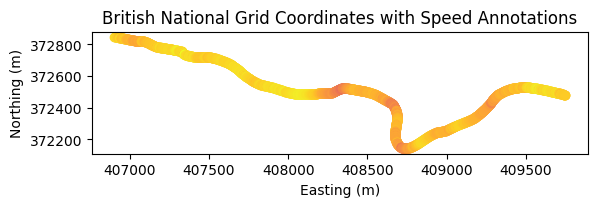

In [ ]:
all_bng = [lat_lon_to_BGS_X_Y(lat, lon) for lat, lon in zip(df_10hz['latitude'], df_10hz['longitude'])]
x = [coord[0] for coord in all_bng]
y = [coord[1] for coord in all_bng]

df_10hz['easting'] = x
df_10hz['northing'] = y

plot_location(
    x,
    y,
    df_10hz['speed'],
    title="British National Grid Coordinates with Speed Annotations",
    x_label="Easting (m)",
    y_label="Northing (m)"
)

In [ ]:
df_10hz['easting'] = x
df_10hz['northing'] = y

# Accumulated distance

In [ ]:
def get_accumulated_distance(x_pos:list[float], y_pos:list[float]) -> list[float]:
    """Get the accumulated distance from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The accumulated distance
    """
    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)
    distances = np.sqrt(diff_x**2 + diff_y**2)
    accumulated_distance = np.concatenate(([0], np.cumsum(distances)))
    return accumulated_distance

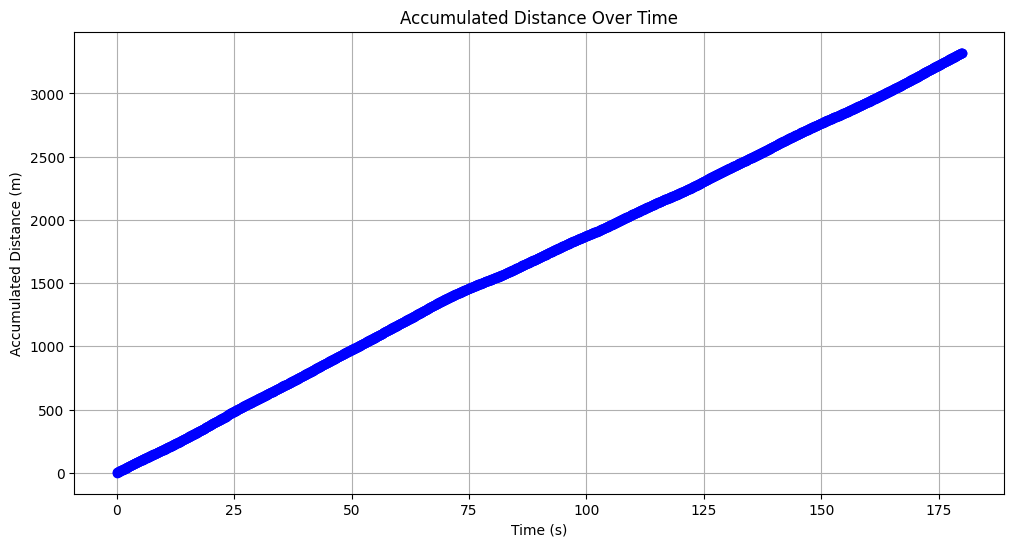

In [ ]:
df_10hz['accumulated_distance'] = get_accumulated_distance(df_10hz['easting'], df_10hz['northing'])

plt.figure(figsize=(12, 6))
plt.plot(df_10hz['time'], df_10hz['accumulated_distance'], marker='o', linestyle='-', color='b')
plt.title('Accumulated Distance Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Accumulated Distance (m)')
plt.grid()
plt.show()

# Angle labeling

/tmp/ipykernel_2729782/1764756339.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  angles = pd.Series(angles).rolling(window=10, center=True).median().fillna(method='bfill').fillna(method='ffill').tolist()


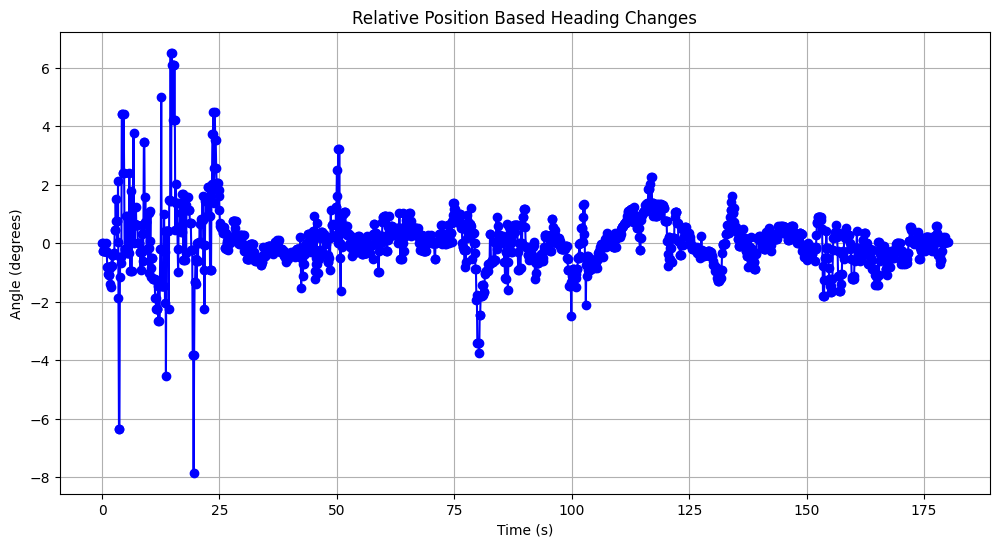

In [ ]:
def relative_position_angles(x, y):
    """
    Calculate the relative position angles between points in a 2D space.
    
    Args:
        x (list): List of x-coordinates.
        y (list): List of y-coordinates.
        
    Returns:
        list: List of angles in degrees.
    """

    angles = []
    for i in range(len(x) - 1):
        angle = math.degrees(math.atan2(y[i + 1] - y[i], x[i + 1] - x[i]))
        angles.append(angle)

    # get first derivative
    angles = [angles[i] - angles[i-1] for i in range(1, len(angles))]

    # normalise angles to -180-180 degrees
    angles = [(angle + 180) % 360 - 180 for angle in angles]

    # apply median filter
    angles = pd.Series(angles).rolling(window=10, center=True).median().fillna(method='bfill').fillna(method='ffill').tolist()

    return angles

angles = relative_position_angles(x, y)
df_10hz['relative_position_based_angle'] = [0,0] + angles

plt.figure(figsize=(12, 6))
plt.plot(df_10hz['time'], df_10hz['relative_position_based_angle'], marker='o', linestyle='-', color='b')
plt.title('Relative Position Based Heading Changes')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.grid()
plt.show()


/tmp/ipykernel_2729782/671169528.py:54: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)


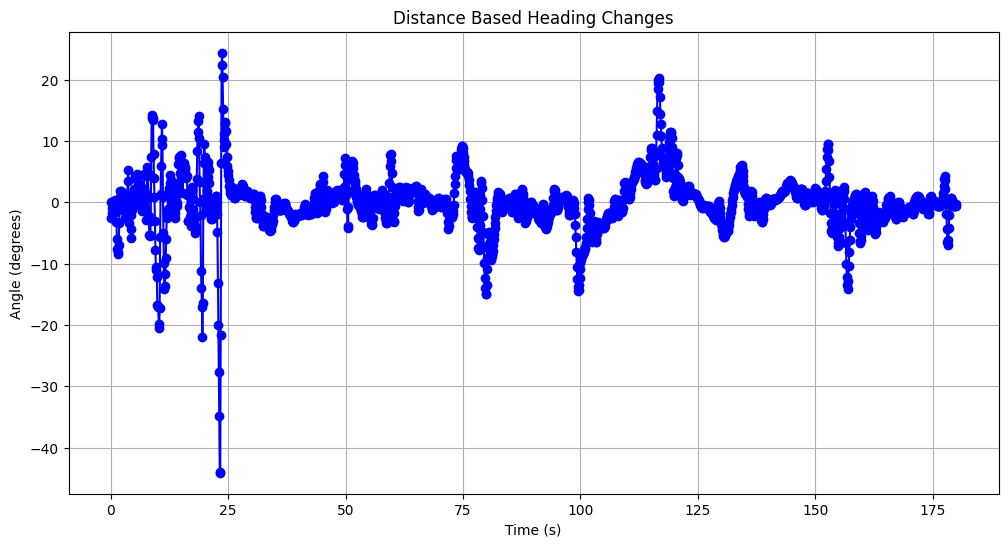

In [ ]:
def get_smoothed_sequence_angles(x_pos:list[float], y_pos:list[float], meters:int = 5) -> list[float]:
    """Get the smoothed sequence angles from x and y positions sequence

    Args:
        x_pos (list[float]): x positions
        y_pos (list[float]): y positions

    Returns:
        list[float]: The smoothed sequence angles
    """

    # x_pos = apply_median_filter(x_pos, 5)
    # y_pos = apply_median_filter(y_pos, 5)

    diff_x = np.diff(x_pos)
    diff_y = np.diff(y_pos)

    accumulated_distance = get_accumulated_distance(x_pos, y_pos)

    angles = []

    for i in range(1, len(accumulated_distance)):
        # find all positions within 5 meters before and after the current position
        current_distance = accumulated_distance[i]
        low_distance = max(0, current_distance - meters)
        high_distance = min(accumulated_distance[-1], current_distance + meters)

        low_index = np.searchsorted(accumulated_distance, low_distance, side='left')
        high_index = np.searchsorted(accumulated_distance, high_distance, side='right')
        high_index = min(high_index, len(accumulated_distance))

        # print(low_index, i, high_index)

        # Before vector (from low_index to i)
        before_vector = np.array([
            np.sum(diff_x[low_index:i]), 
            np.sum(diff_y[low_index:i])
        ])
        

        # After vector (from i to high_index)
        after_vector = np.array([
            np.sum(diff_x[i:high_index]), 
            np.sum(diff_y[i:high_index])
        ])
        
        # Check zero vectors
        if np.linalg.norm(before_vector) == 0 or np.linalg.norm(after_vector) == 0:
            angles.append(0.0)
            continue
        
        # Compute angle using vector operations
        dot = np.dot(before_vector, after_vector)
        cross = np.cross(before_vector, after_vector)  # Cross product magnitude (z-component)
        angle = np.arctan2(cross, dot)
        
        angles.append(angle)

    angles_rad = np.array(angles)
    complex_angles = np.exp(1j * angles_rad)

    # smooth angles with gaussian filter
    gaussian = np.exp(-np.linspace(-2, 2, 5)**2)
    gaussian /= gaussian.sum()
    smoothed_complex = np.convolve(complex_angles, gaussian, mode='same')

    # Convert back to angles
    smoothed_angles = np.angle(smoothed_complex)
    smoothed_degrees = np.degrees(smoothed_angles)

    return smoothed_degrees

smoothed_angles = get_smoothed_sequence_angles(x, y, 10)
df_10hz['smoothed_angles'] = [0] + smoothed_angles.tolist()[:len(df_10hz) - 1]
plt.figure(figsize=(12, 6))
plt.plot(df_10hz['time'], df_10hz['smoothed_angles'], marker='o', linestyle='-', color='b')
plt.title('Distance Based Heading Changes')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.grid()
plt.show()

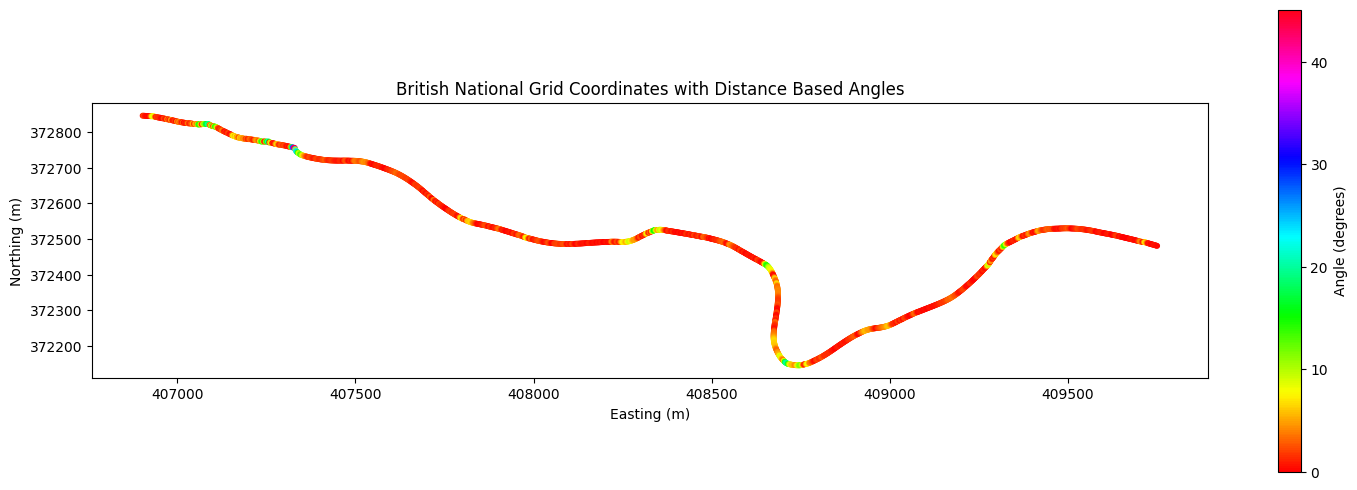

In [194]:
from matplotlib.colors import Normalize

def plot_location_with_angles(x, y, angles, title=None, x_label='Longitude', y_label='Latitude'):
    """
    Plot longitude and latitude on a map with angles.
    
    Args:
        x (list): List of x-coordinates.
        y (list): List of y-coordinates.
        angles (list): List of angles in degrees.
        title (str): Title of the plot.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
    """
    angles = np.array(angles)  
    angles = np.abs(angles) 

    norm = Normalize(vmin=0, vmax= angles.max()+1)
    fig, ax = plt.subplots(figsize=(18, 6))
    sc = ax.scatter(
        x, y,
        c=angles,           # raw data
        cmap='hsv',         # choose a cyclic colormap if this is a direction
        norm=norm,
        s=10
    )
    plt.colorbar(sc, label='Angle (degrees)')

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_aspect('equal', adjustable='box')
    if title:
        ax.set_title(title)
    plt.show()
    


plot_location_with_angles(
    df_10hz['easting'],
    df_10hz['northing'],
    df_10hz['smoothed_angles'],
    title="British National Grid Coordinates with Distance Based Angles",
    x_label="Easting (m)",
    y_label="Northing (m)"
)

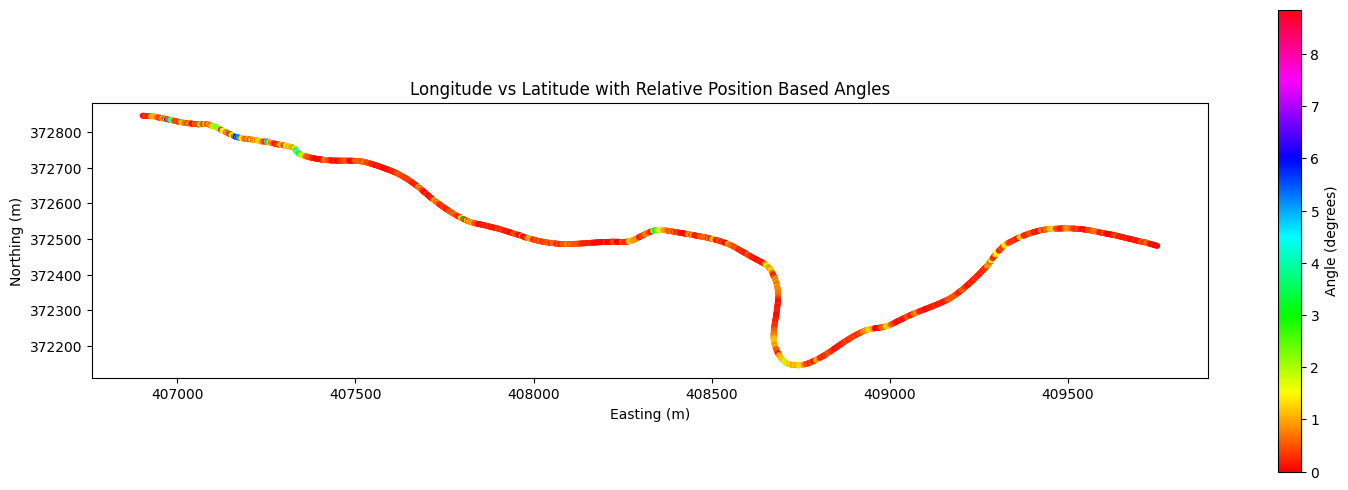

In [195]:
plot_location_with_angles(
    df_10hz['easting'],
    df_10hz['northing'],
    df_10hz['relative_position_based_angle'],
    title="Longitude vs Latitude with Relative Position Based Angles",
    x_label="Easting (m)",
    y_label="Northing (m)"
)

# Choosing a appropriate threshold angle

Elbow at 7.161905575134769 degrees


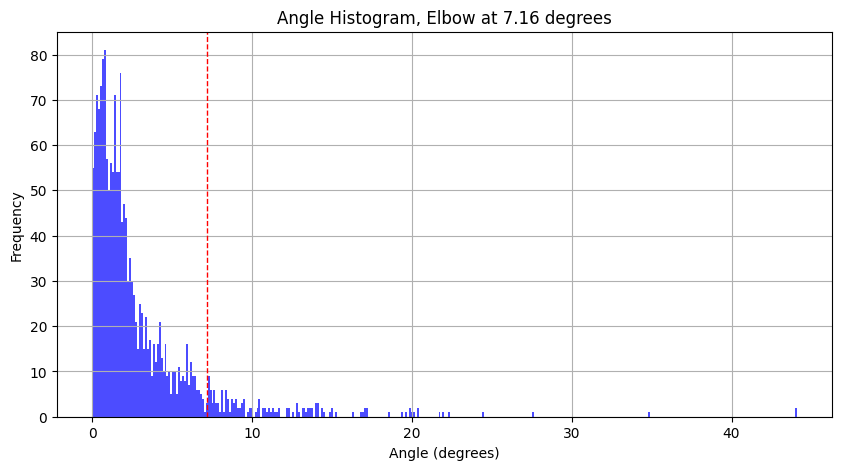

In [196]:
# angle histogram
counts, bin_edges = np.histogram(np.abs(df_10hz['smoothed_angles']), bins=(40), density=True)
bins = (bin_edges[:-1] + bin_edges[1:]) / 2
kl = KneeLocator(bins, counts, curve='convex', direction='decreasing')
print("Elbow at", kl.knee, "degrees")

plt.figure(figsize=(10, 5))
plt.hist(np.abs((df_10hz['smoothed_angles'])), bins=360, color='blue', alpha=0.7)
plt.axvline(kl.knee, color='red', linestyle='dashed', linewidth=1, label=f'Elbow at {kl.knee:.2f} degrees')
plt.title(f'Angle Histogram, Elbow at {kl.knee:.2f} degrees')
plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.grid()
plt.savefig(os.path.join(OUTPUT_PATH, f"angle_histogram.png"), dpi=300)
plt.show()

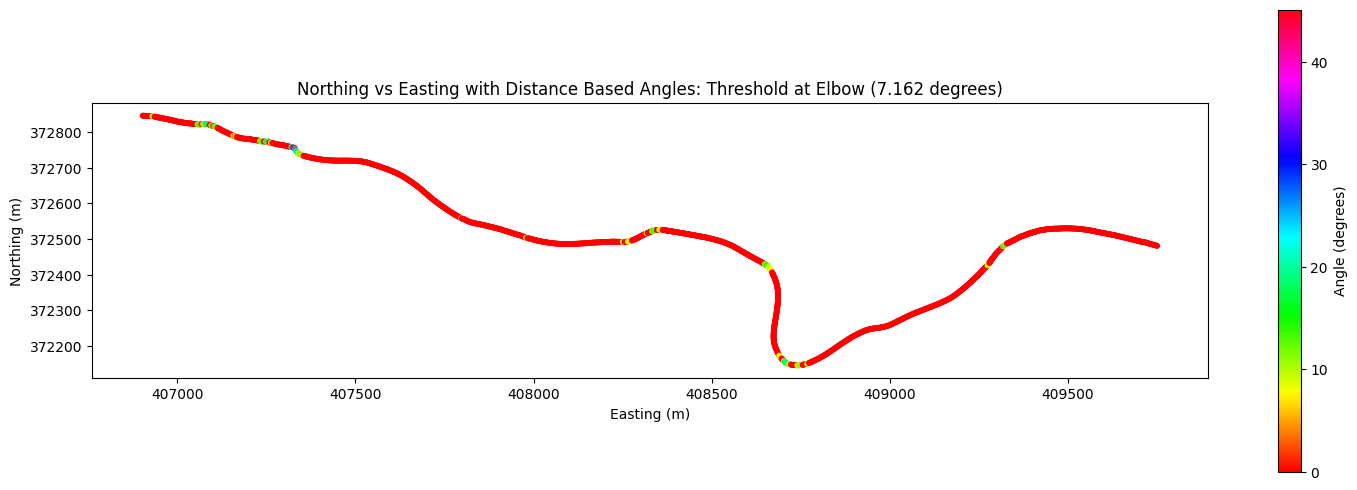

In [197]:
plot_location_with_angles(
    df_10hz['easting'],
    df_10hz['northing'],
    [angle if abs(angle) > kl.knee else 0 for angle in df_10hz['smoothed_angles']],
    title=f"Northing vs Easting with Distance Based Angles: Threshold at Elbow ({round(kl.knee,3)} degrees)",
    x_label="Easting (m)",
    y_label="Northing (m)",
)

In [198]:
# median_filter = 10
# def apply_median_filter(data, window_size):
#     """Apply a median filter to the data.

#     Args:
#         data (list): The data to filter.
#         window_size (int): The size of the median filter window.

#     Returns:
#         list: The filtered data.
#     """
#     return pd.Series(data).rolling(window=window_size, center=True).median().fillna(method='bfill').fillna(method='ffill').tolist()

# df_10hz['smoothed_angles'] = apply_median_filter(df_10hz['smoothed_angles'], median_filter)

In [199]:
# 1) Pick a numerical threshold (e.g. 95th percentile of your angles)
angles = np.abs(df_10hz['smoothed_angles'])

cluster_threshold_percentile = 90
cluster_threshold = np.percentile(angles, cluster_threshold_percentile)
print(f"Using threshold = {cluster_threshold:.2f}°")

# 2) Build a boolean mask of where you exceed that threshold
mask = angles > cluster_threshold

# 3) Turn each contiguous run of True into its own cluster ID
#    (Whenever mask flips, we bump the cluster counter)
cluster_id = (mask != mask.shift()).cumsum()

# 4) Attach to your DataFrame
df = df_10hz.copy()
df['above_thresh'] = mask
df['cluster']      = cluster_id

# 5) Group only those rows above threshold, and summarize
clusters = (
    df[df.above_thresh]
      .groupby('cluster')
      .agg(
         start_idx = ('smoothed_angles', lambda s: s.index[0]),
         end_idx   = ('smoothed_angles', lambda s: s.index[-1]),
         avg_angle = ('smoothed_angles', 'mean'),
         n_points  = ('smoothed_angles', 'size'),
       )
      .reset_index(drop=True)
)

# round average angle to 2 decimal places
clusters['avg_angle'] = clusters['avg_angle'].round(2)

clusters

Using threshold = 6.47°


,start_idx,end_idx,avg_angle,n_points
0,15,18,-7.78,4
1,87,92,11.71,6
2,96,105,-14.98,10
3,109,111,10.84,3
4,114,118,-11.68,5
5,146,147,7.30,2
6,149,150,7.61,2
7,185,189,11.54,5
8,193,197,-16.12,5
9,200,201,8.45,2


In [200]:
MAX_GAP = 30  # number of indices (or tune this as meters or seconds)
merged_clusters = []
prev_cluster = None

for _, row in clusters.iterrows():
    if prev_cluster is None:
        prev_cluster = row
        continue
    
    # Check if this cluster is close enough to previous one
    start_accumulated_distance = df_10hz['accumulated_distance'][row['start_idx']]
    end_accumulated_distance = df_10hz['accumulated_distance'][prev_cluster['end_idx']] 

    if abs(start_accumulated_distance - end_accumulated_distance) <= MAX_GAP:
        # Merge clusters
        prev_cluster['end_idx'] = row['end_idx']

        prev_cluster['avg_angle'] = (
            prev_cluster['avg_angle'] * prev_cluster['n_points'] +
            row['avg_angle'] * row['n_points']
        ) / (prev_cluster['n_points'] + row['n_points'])

        prev_cluster['n_points'] += row['n_points']
    else:
        merged_clusters.append(prev_cluster)
        prev_cluster = row

if prev_cluster is not None:
    merged_clusters.append(prev_cluster)

clusters = pd.DataFrame(merged_clusters).reset_index(drop=True)

# make start_idx and end_idx intagers
clusters['start_idx'] = clusters['start_idx'].astype(int)
clusters['end_idx'] = clusters['end_idx'].astype(int)

clusters

,start_idx,end_idx,avg_angle,n_points
0,15,18,-7.780000,4.0
1,87,118,-4.392500,24.0
2,146,150,7.455000,4.0
3,185,209,0.044615,13.0
4,229,248,-2.007895,19.0
5,500,515,6.935000,2.0
6,596,598,7.400000,3.0
7,736,753,7.775714,14.0
8,783,815,-9.877895,19.0
9,992,1012,-9.990000,21.0


In [201]:
def calculate_average_speed_for_range(speeds, start, end):
    """Calculate the average speed for a given range of indices.

    Args:
        speeds (list): List of speeds.
        start (int): Start index.
        end (int): End index.

    Returns:
        float: Average speed for the range.
    """
    return np.mean(speeds[start:end]) if end > start else 0.0

clusters['avg_speed'] = [
    calculate_average_speed_for_range(
        df_10hz['speed'].values, 
        int(clusters['start_idx'][i]), 
        int(clusters['end_idx'][i])
    ) for i in range(len(clusters))
]

# round average speed to 2 decimal places
clusters['avg_speed'] =  clusters['avg_speed'].round(2)

clusters

,start_idx,end_idx,avg_angle,n_points,avg_speed
0,15,18,-7.780000,4.0,43.90
1,87,118,-4.392500,24.0,40.81
2,146,150,7.455000,4.0,42.88
3,185,209,0.044615,13.0,44.40
4,229,248,-2.007895,19.0,45.02
5,500,515,6.935000,2.0,43.52
6,596,598,7.400000,3.0,45.00
7,736,753,7.775714,14.0,36.28
8,783,815,-9.877895,19.0,32.78
9,992,1012,-9.990000,21.0,33.73


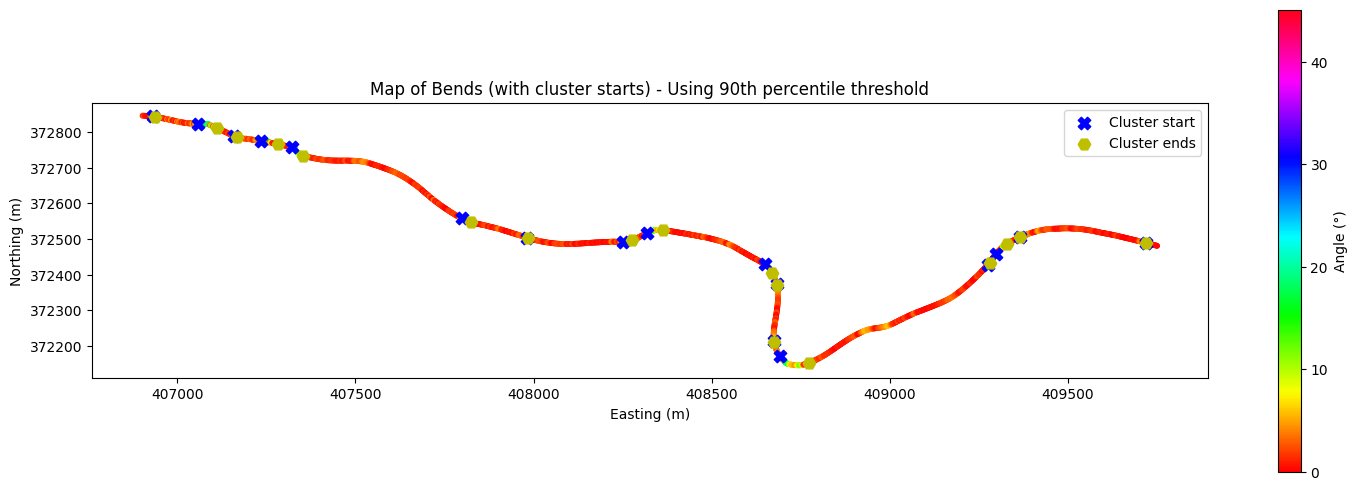

In [202]:

def plot_location_with_angles(
    x, y, angles,
    title=None,
    clusters=None,
    x_label='Longitude', y_label='Latitude',
    savefig=False,
    ):
    """
    Plot lon/lat colored by angle, and mark the start of each 'bend' cluster.
    
    Args:
        x, y         : sequences of coordinates
        angles       : sequence of angles in degrees
        threshold    : numeric cutoff for a “significant” bend;
                       if None, use the thresh_pctile percentile
        thresh_pctile: percentile to use if threshold is None
    """
    angles = np.abs(np.array(angles))
    
    # build the scatter
    norm = Normalize(vmin=0, vmax=angles.max()+1)
    fig, ax = plt.subplots(figsize=(18, 6))
    sc = ax.scatter(x, y,
                    c=angles,
                    cmap='hsv',
                    norm=norm,
                    s=10)
    plt.colorbar(sc, label='Angle (°)')

    if clusters is not None and 'start_idx' in clusters:
        starts = clusters['start_idx'].values
        ends = clusters['end_idx'].values
        ax.scatter(
            np.array(x)[starts],
            np.array(y)[starts],
            marker='X',
            c='b',
            s=80,
            label='Cluster start'
        )
        ax.scatter(
            np.array(x)[ends],
            np.array(y)[ends],
            marker='H',
            c='y',
            s=80,
            label='Cluster ends',
        )
        ax.legend(loc='upper right')    
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    ax.legend(loc='upper right')
    if savefig:
        plt.savefig(os.path.join(OUTPUT_PATH, f"bend_map.png"), dpi=300)
    plt.show()

plot_location_with_angles(
    x, y, df_10hz['smoothed_angles'],
    title=f"Map of Bends (with cluster starts) - Using {cluster_threshold_percentile}th percentile threshold",
    clusters=clusters,
    x_label="Easting (m)",
    y_label="Northing (m)",
    savefig=True
)

# Associate frame to start time

In [203]:
def time_to_frame(time:float, fps:int) -> int:
    """Convert time in seconds to frame number

    Args:
        time (float): Time in seconds
        fps (int): Frames per second

    Returns:
        int: Frame number
    """
    return int(time * fps) if time > 0 else 0

clusters['start_frame'] = clusters['start_idx'].apply(lambda x: time_to_frame(df_10hz['time'][x], FRAME_RATE))

In [204]:
clusters

,start_idx,end_idx,avg_angle,n_points,avg_speed,start_frame
0,15,18,-7.780000,4.0,43.90,41
1,87,118,-4.392500,24.0,40.81,257
2,146,150,7.455000,4.0,42.88,434
3,185,209,0.044615,13.0,44.40,551
4,229,248,-2.007895,19.0,45.02,683
5,500,515,6.935000,2.0,43.52,1495
6,596,598,7.400000,3.0,45.00,1783
7,736,753,7.775714,14.0,36.28,2202
8,783,815,-9.877895,19.0,32.78,2343
9,992,1012,-9.990000,21.0,33.73,2970


In [217]:
def output_frame(index, filepath, filename):
    """Output the frame to the output folder

    Args:
        index (int): The frame index
        filepath (str): The path to the video file
        filename (str): The output filename
    """
    video = cv2.VideoCapture(filepath)
    video.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = video.read()
    if ret:
        cv2.imwrite(os.path.join(OUTPUT_PATH, f"{filename}.jpg"), frame)
    video.release()

for i, row in clusters.iterrows():
    direction = "left" if row['avg_angle'] > 0 else "right"
    formatted_angle = f"{abs(row['avg_angle']):.2f}"

    output_frame(row['start_frame'], INPUT_FILE, f"bend_{i}_{direction}_{formatted_angle}")

# Calculate frame at distance

In [206]:
def get_frame_at_x_meters_before(start_index:int, accumulated_distances:list[float], meters:int) -> int:
    if start_index >= len(accumulated_distances):
        raise ValueError("Start index is out of bounds for the accumulated distances list.")
    
    start_distance = accumulated_distances[start_index]
    
    # linear search for the end index for x meters before start_distance
    end_index = start_index
    while end_index >= 0 and accumulated_distances[end_index] > start_distance - meters:
        end_index -= 1
        
    # bounds check
    if end_index < 0:
        return -1
    
    time = df_10hz['time'].iloc[end_index]
    frame = time_to_frame(time, FRAME_RATE)
    if frame >= TOTAL_FRAME_COUNT:
        return -1
    return frame

In [207]:
for distance in distances:
    clusters[f'{distance} meters frame'] = clusters['start_idx'].apply(
        lambda x: get_frame_at_x_meters_before(x, df_10hz['accumulated_distance'].values, distance)
    )

set infringements on previous bends to -1

In [208]:
previous_frame_start = clusters['start_frame'].values[0]
for i, row in clusters.iterrows():
    if row['start_frame'] == previous_frame_start:
        continue

    frame_values = []
    for distance in distances:
        val = row[f'{distance} meters frame']
        if val == -1:
            frame_values.append(-1)
        else:
            if val <= previous_frame_start:
                frame_values.append(-1)
            else:
                frame_values.append(val)
    previous_frame_start = row['start_frame']

    for j in range(len(frame_values)):
        clusters.loc[i, f'{distances[j]} meters frame'] = frame_values[j]

clusters

,start_idx,end_idx,avg_angle,n_points,avg_speed,start_frame,10 meters frame,20 meters frame,30 meters frame,40 meters frame,50 meters frame,75 meters frame,100 meters frame
0,15,18,-7.780000,4.0,43.90,41,26,11,-1,-1,-1,-1,-1
1,87,118,-4.392500,24.0,40.81,257,242,224,206,188,173,131,92
2,146,150,7.455000,4.0,42.88,434,419,404,389,374,356,317,275
3,185,209,0.044615,13.0,44.40,551,536,521,506,491,476,440,-1
4,229,248,-2.007895,19.0,45.02,683,671,656,641,626,611,575,-1
5,500,515,6.935000,2.0,43.52,1495,1480,1465,1450,1435,1417,1381,1342
6,596,598,7.400000,3.0,45.00,1783,1771,1756,1741,1726,1711,1672,1636
7,736,753,7.775714,14.0,36.28,2202,2187,2169,2151,2133,2115,2076,2037
8,783,815,-9.877895,19.0,32.78,2343,2325,2304,2286,2265,2247,-1,-1
9,992,1012,-9.990000,21.0,33.73,2970,2952,2934,2916,2898,2880,2838,2796


In [209]:
clusters.to_csv(os.path.join(OUTPUT_PATH, f"clusters.csv"), index=False)

# Generate Training Videos

In [210]:
MIN_FRAME = 0
MAX_FRAME = TOTAL_FRAME_COUNT
SAMPLE_VIDEO_LENGTH = 60

In [211]:
def resize_frame_to_224(frame):
    """Resize the frame to 224x224

    Args:
        frame (np.ndarray): The frame

    Returns:
        np.ndarray: The resized frame
    """
    # crop 20% off left and right
    frame = frame[:, int(frame.shape[1] * 0.2):int(frame.shape[1] * 0.8)]

    # crop 25% off top and bottom 
    frame = frame[int(frame.shape[0] * 0.25):int(frame.shape[0] * 0.75), :]

    return cv2.resize(frame, (224, 224))

In [212]:
def get_dense_optic_flow_u_v_flow(initial_frame, next_frame): 
    initial_frame_gray = cv2.cvtColor(initial_frame, cv2.COLOR_BGR2GRAY)
    next_frame_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # reduce image size
    initial_frame_gray = cv2.resize(initial_frame_gray, (int(initial_frame_gray.shape[1] * 0.5), int(initial_frame_gray.shape[0] * 0.5)))
    next_frame_gray = cv2.resize(next_frame_gray, (int(next_frame_gray.shape[1] * 0.5), int(next_frame_gray.shape[0] * 0.5)))

    flow = cv2.calcOpticalFlowFarneback(initial_frame_gray, next_frame_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    u = flow[..., 0]
    v = flow[..., 1]

    scale = 0.5

    u = u * scale
    v = v * scale

    mid = 255//2

    u = (u + mid).astype(np.uint8)
    v = (v + mid).astype(np.uint8)

    # hard clipping
    u = np.clip(u, 0, 255)
    v = np.clip(v, 0, 255)

    return u, v

In [213]:
def save_avi_from_to(path, from_frame, to_frame):
    """Save a video from a given frame to another

    Args:
        path (str): The path to the video
        from_frame (int): The starting frame
        to_frame (int): The ending frame
    """

    cap = cv2.VideoCapture(INPUT_FILE, cv2.CAP_FFMPEG)

    ret, sample_frame = cap.read()

    if not ret:
        raise ValueError(f"Could not read frame {from_frame} from {FILE_NAME}")

    sample_frame = resize_frame_to_224(sample_frame)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(f"image shape: {sample_frame.shape}")

    out = cv2.VideoWriter(path, fourcc, 15.0, (int(sample_frame.shape[1]), int(sample_frame.shape[0])))

    cap.set(cv2.CAP_PROP_POS_FRAMES, from_frame)
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            frame = resize_frame_to_224(frame)
            out.write(frame)
        else:
            break

        ret, frame = cap.read() # skip a frame

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= to_frame:
            break

    cap.release()
    out.release()

In [214]:
def save_optic_flow_avi_from_to(path, from_frame, to_frame):
    """Save a video from a given frame to another

    Args:
        path (str): The path to the video
        from_frame (int): The starting frame
        to_frame (int): The ending frame
    """

    cap = cv2.VideoCapture(INPUT_FILE, cv2.CAP_FFMPEG)
    cap.set(cv2.CAP_PROP_POS_FRAMES, from_frame)

    # compensate for the skipped frame
    to_frame = min(to_frame+1, MAX_FRAME)

    last_frame = cap.read()[1]

    sample_frame = resize_frame_to_224(last_frame)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    
    print(f"image shape: {sample_frame.shape}")

    out = cv2.VideoWriter(path, fourcc, 15.0, (int(sample_frame.shape[1]), int(sample_frame.shape[0])))

    
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            next_frame = frame
          
            u_change, v_change = get_dense_optic_flow_u_v_flow(last_frame, next_frame)

            new_image = np.ones((u_change.shape[0], u_change.shape[1], 3), dtype=np.uint8)
            new_image[..., 0] = u_change
            new_image[..., 1] = v_change

            new_image = resize_frame_to_224(new_image)

            last_frame = next_frame

            # set last channel to grayscale of original frame
            frame = resize_frame_to_224(frame)
            new_image[..., 2] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


            out.write(new_image)
        else:
            break

        ret, frame = cap.read() # skip a frame

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= to_frame:
            break

    cap.release()
    out.release()

## Run the training video generation

In [215]:
RGB_bend_output_folder = os.path.join(OUTPUT_PATH, f"RGB")
if not os.path.exists(RGB_bend_output_folder):
    os.makedirs(RGB_bend_output_folder)

OPTIC_FLOW_bend_output_folder = os.path.join(OUTPUT_PATH, f"OpticFlow")
if not os.path.exists(OPTIC_FLOW_bend_output_folder):
    os.makedirs(OPTIC_FLOW_bend_output_folder)

In [ ]:
for i, row in clusters.iterrows():
    print(f"Processing bend {i}")

    distance_frames = []

    for distance in distances:
        distance_frames.append(row[f'{distance} meters frame'])

    if all([frame == -1 for frame in distance_frames]):
        print(f"Skipping bend {i} as all frames are -1")
        continue

    _direction = "left" if row['avg_angle'] > 0 else "right"
    _speed = row['avg_speed']
    _avg_angle = row['avg_angle']

    # os.path.join(samples_output_folder, f"bend_{i}_{start_frame}_{end_frame}_{direction}_{speed}_{avg_angle}_{distance}_meters_before.avi")
    for s_i in range(len(distance_frames)):
        sample_start_frame = distance_frames[s_i]
        sample_distance = distances[s_i]

        if sample_start_frame == -1:
            print(f"Skipping bend {i} as distance {sample_distance} is -1")
            continue

        sample_end_frame = sample_start_frame + SAMPLE_VIDEO_LENGTH
        
        if sample_end_frame > TOTAL_FRAME_COUNT:
            print(f"Skipping bend {i} as end frame {sample_end_frame} is greater than total frame count {TOTAL_FRAME_COUNT}")
            continue


        sample_file_name = f"bend_{i}_{sample_start_frame}_{sample_end_frame}_{_direction}_{_speed}_{_avg_angle}_{sample_distance}_meters_before.avi"

        sample_file_path_rgb = os.path.join(
            RGB_bend_output_folder,
            sample_file_name
        )

        sample_file_path_optic_flow = os.path.join(
            OPTIC_FLOW_bend_output_folder,
            sample_file_name
        )      

        print(f"Saving sample RGB video to {sample_file_path_rgb}")
        save_avi_from_to(sample_file_path_rgb, sample_start_frame, sample_end_frame)

        print(f"Saving sample optic flow video to {sample_file_path_optic_flow}")
        save_optic_flow_avi_from_to(sample_file_path_optic_flow, sample_start_frame, sample_end_frame)